In [4]:
# !pip install sbi

import torch
import numpy as np
from scipy.signal import welch
from sbi import utils as sbi_utils
from sbi.inference import SNPE
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tensorflow.keras.models import load_model

In [5]:


#  Load Trained Generator
generator = load_model("saved_models/qpo_cgan_phy_generator.keras")

# --- Hyperparameters ---
latent_dim = 100
num_simulations = 5000
num_test_samples = 100

#  Prior: fc ∈ [0.01, 1.0], amp ∈ [0.1, 1.0]
prior = sbi_utils.BoxUniform(low=torch.tensor(
    [0.01, 0.1]), high=torch.tensor([1.0, 1.0]))

#  GAN-based simulator for SBI


def simulator(theta):
    fc, amp = theta.numpy()
    z = torch.randn((1, latent_dim))
    label = torch.tensor([[fc, amp, 1.0]], dtype=torch.float32)  # force QPO
    generated = generator([z, label], training=False).numpy().squeeze()
    f, Pxx = welch(generated, fs=1, nperseg=256)
    return torch.tensor(Pxx, dtype=torch.float32)


# --- Generate Simulations
print("Generating synthetic QPOs for SBI...")
thetas = prior.sample((num_simulations,))
xs = torch.stack([simulator(theta) for theta in thetas])

# --- Train SBI Posterior
inference = SNPE(prior)
density_estimator = inference.append_simulations(thetas, xs).train()
posterior = inference.build_posterior(density_estimator)

#  Save Trained Posterior
torch.save(posterior, "saved_models/trained_sbi_posterior.pt")
print(" SBI Posterior trained and saved.")

Generating synthetic QPOs for SBI...
 Neural network successfully converged after 52 epochs. SBI Posterior trained and saved.


In [ ]:
import numpy as np
import torch
from scipy.signal import welch
import matplotlib.pyplot as plt
import seaborn as sns


def run_grid_sbi_evaluation(generator, posterior, latent_dim=100,
                            fc_vals=np.linspace(0.01, 0.5, 8),
                            amp_vals=np.linspace(0.1, 1.0, 8),
                            num_samples=500):
    """
    Run full-loop inference on a grid of fc/amp values and collect mean errors.
    Returns 2D arrays of errors.
    """

    fc_error_map = np.zeros((len(fc_vals), len(amp_vals)))
    amp_error_map = np.zeros((len(fc_vals), len(amp_vals)))

    for i, fc in enumerate(fc_vals):
        for j, amp in enumerate(amp_vals):
            # Step 1: Generate GAN sample
            label = torch.tensor([[fc, amp, 1.0]], dtype=torch.float32)
            z = torch.randn((1, latent_dim))
            signal = generator([z, label], training=False).numpy().squeeze()

            # Step 2: Compute PSD
            f, Pxx = welch(signal, fs=1, nperseg=256)
            x_obs = torch.tensor(Pxx, dtype=torch.float32)

            # Step 3: Run SBI inference
            samples = posterior.sample(
                (num_samples,), x=x_obs, show_progress_bars=False)
            fc_pred = samples[:, 0].mean().item()
            amp_pred = samples[:, 1].mean().item()

            # Step 4: Record absolute error
            fc_error_map[i, j] = abs(fc_pred - fc)
            amp_error_map[i, j] = abs(amp_pred - amp)

    return fc_vals, amp_vals, fc_error_map, amp_error_map


def plot_error_heatmaps(fc_vals, amp_vals, fc_errs, amp_errs):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    sns.heatmap(fc_errs, xticklabels=np.round(amp_vals, 2), yticklabels=np.round(fc_vals, 2),
                ax=axs[0], cmap="Blues", annot=True)
    axs[0].set_title("FC Error Heatmap")
    axs[0].set_xlabel("Amplitude")
    axs[0].set_ylabel("FC (Hz)")

    sns.heatmap(amp_errs, xticklabels=np.round(amp_vals, 2), yticklabels=np.round(fc_vals, 2),
                ax=axs[1], cmap="Oranges", annot=True)
    axs[1].set_title("Amplitude Error Heatmap")
    axs[1].set_xlabel("Amplitude")
    axs[1].set_ylabel("FC (Hz)")

    plt.suptitle("SBI Inference Error Across FC-Amplitude Grid")
    plt.tight_layout()
    plt.show()

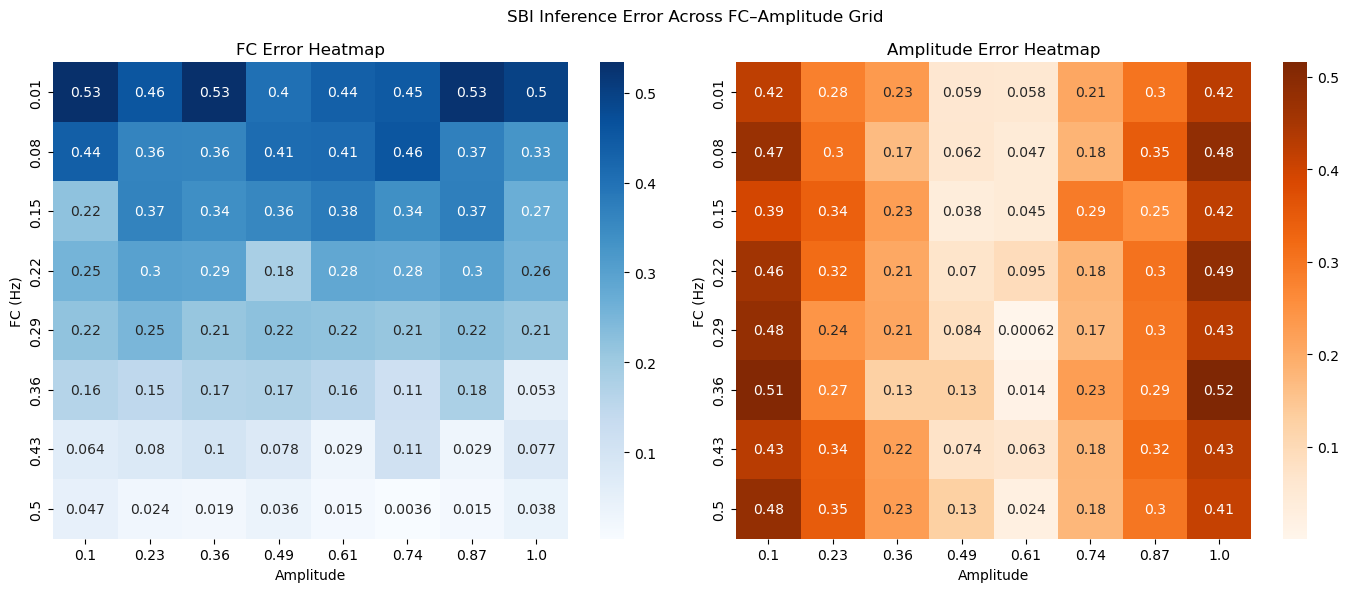

In [ ]:
# Load posterior (already trained and saved)
posterior = torch.load("saved_models/trained_sbi_posterior.pt")

generator = load_model("saved_models/qpo_cgan_phy_generator.keras")

fc_vals, amp_vals, fc_errs, amp_errs = run_grid_sbi_evaluation(
    generator, posterior)
plot_error_heatmaps(fc_vals, amp_vals, fc_errs, amp_errs)